In [9]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

In [10]:
engine = create_engine("sqlite:///hawaii_6.sqlite")

Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurements', 'stations']

In [11]:
session = Session(engine)

In [12]:
measurements = Base.classes.measurements
stations = Base.classes.stations

In [24]:
one_year = dt.date.today() - dt.timedelta(days=730)
one_year

datetime.date(2016, 7, 30)

,prcp
count,2153.000000
mean,0.184292
std,0.470654
min,0.000000
25%,0.000000
50%,0.020000
75%,0.140000
max,6.700000


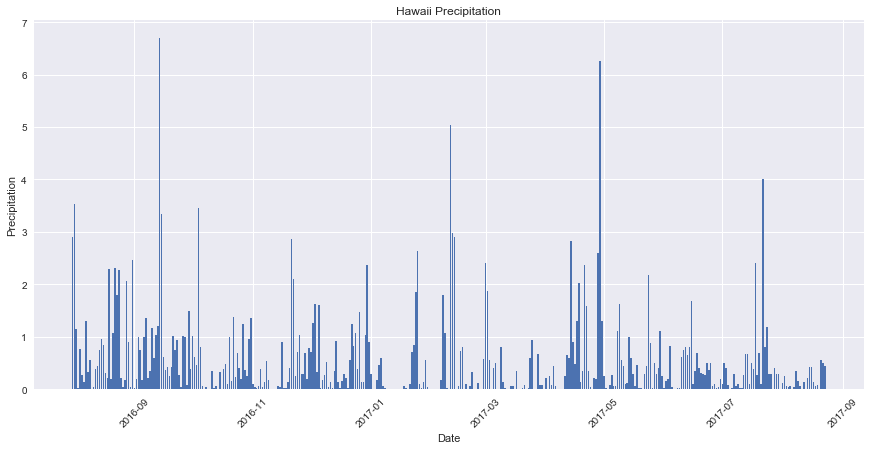

In [35]:
precip_analysis = session.query(measurements.date, measurements.prcp).filter(measurements.date > one_year).order_by(measurements.date).all()
precip_pd = pd.DataFrame(precip_analysis, columns = ['date', 'prcp'])
precip_pd.set_index(precip_pd['date'], inplace = True)

plt.figure(figsize = (12, 6))
plt.bar(precip_pd['date'], precip_pd['prcp'])
plt.xticks(rotation='45')
plt.tight_layout()
plt.title('Hawaii Precipitation')
plt.xlabel("Date")
plt.ylabel("Precipitation")
precip_pd.describe()

In [36]:
stations  = session.query(stations).count()
stations

9

In [49]:
sel = [measurements.station, func.count(measurements.tobs)]
most_active = session.query(*sel).group_by(measurements.station).order_by(func.count(measurements.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [50]:
most_active[0]

('USC00519281', 2772)

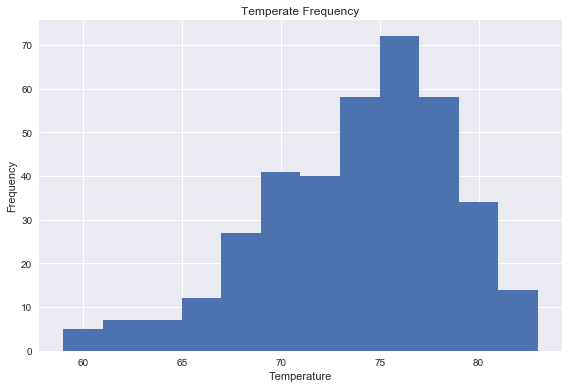

In [64]:
results = session.query(measurements.tobs).\
    filter(measurements.date > one_year).\
    filter(measurements.station == most_active[0][0]).\
    order_by(measurements.date).all()
import numpy as np

tobs = list(np.ravel(results))
plt.title("Temperate Frequency")
plt.hist(tobs, 12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.tight_layout()

['2016-01-21', '2016-01-29']


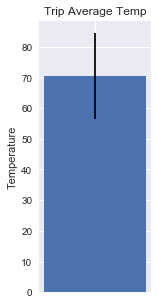

In [70]:
def calc_temps(start_date, end_date):
    dates = [start_date, end_date]
    new_dates = []
    for date in dates:
        date_list = date.split("-")
        date_list[0] = str(int(date_list[0]) - 1)
        new_date = "-".join(date_list)
        new_dates.append(new_date)
    print(new_dates) 
    
    temp_values = session.query(measurements.tobs)\
    .filter(measurements.date >= new_dates[0], measurements.date <= new_dates[1]).all()
    temp_values_list = [x for (x,) in temp_values]
    avg_temp = np.mean(temp_values_list)
    max_temp = max(temp_values_list)
    min_temp = min(temp_values_list)
    
    plt.figure(figsize=(2,5))    
    plt.title("Trip Average Temp")
    plt.ylabel("Temperature")
    plt.bar(1, avg_temp, yerr = (max_temp - min_temp), tick_label = "")
    plt.show()
    
calc_temps('2017-01-21', '2017-01-29')


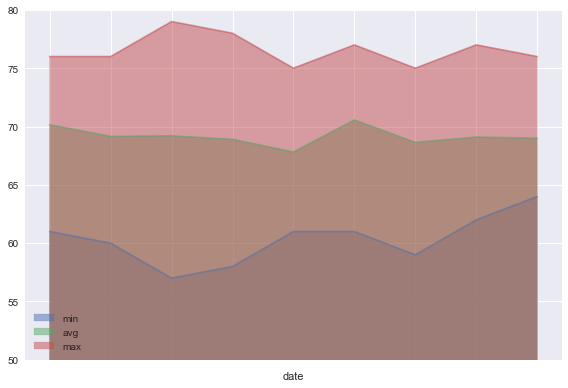

In [90]:
trip_dates = pd.date_range('2017-01-21', '2017-01-29', freq='D').strftime('%m-%d')

sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
weather = []
weather_final = []
for date in trip_dates:
    weather.append(session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all())
for wea in weather:
    weather_final.append(wea[0])
weather_df = pd.DataFrame(weather_final, columns=['min', 'avg', 'max'])
weather_df['date'] = trip_dates
weather_df.set_index(['date'], inplace=True)
weather_df.plot(kind='area', stacked=False, x_compat=True, alpha=.5)
plt.ylim(50,80)
plt.tight_layout()